<a href="https://colab.research.google.com/github/dh610/ai-intensive2/blob/main/lab11/RLHF-trl-small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ai-intensive2
!git pull
%cd lab11

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ai-intensive2
Already up to date.
/content/drive/MyDrive/ai-intensive2/lab11


In [5]:
!pip install -q transformers datasets trl==0.8.0 peft

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead
from peft import LoraConfig
import numpy as np
from pprint import pprint
from transformers.utils import logging

logging.set_verbosity_error()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
reward_model_id = "OpenAssistant/reward-model-deberta-v3-large-v2"

rm_tokenizer = AutoTokenizer.from_pretrained(reward_model_id)
rm_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id).eval().to(device)

if "cuda" in device:
  rm_model.half()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [7]:
@torch.no_grad()
def get_scores(prompts, answers, print_input=False):
  inputs = rm_tokenizer(prompts, answers,
                        truncation=True,
                        padding=True,
                        max_length=512,
                        return_tensors="pt").to(device)

  if print_input:
    print(rm_tokenizer.batch_decode(inputs["input_ids"], skip_special_tokens=False))
  scores = rm_model(**inputs).logits.squeeze(1)
  return scores

print(
    get_scores(
      ["I just came out of from jail, any suggestion of my future?"],
      ["It's great to hear that you have been released from jail."],
      True
    )
)
print(
    get_scores(
      ["I just came out of from jail, any suggestion of my future?"],
      ["Go back to jail you scum"],
      True
    )
)

["[CLS] I just came out of from jail, any suggestion of my future?[SEP] It's great to hear that you have been released from jail.[SEP]"]
tensor([-2.5898], device='cuda:0', dtype=torch.float16)
['[CLS] I just came out of from jail, any suggestion of my future?[SEP] Go back to jail you scum[SEP]']
tensor([-4.1523], device='cuda:0', dtype=torch.float16)


In [8]:
model_id = "vicgalle/gpt2-alpaca-gpt4"


query_tokenizer = AutoTokenizer.from_pretrained(model_id)
query_tokenizer.padding_side = "left"
query_tokenizer.truncation_side = "left"
if query_tokenizer.pad_token_id is None:
  query_tokenizer.pad_token_id = query_tokenizer.eos_token_id

response_tokenizer = AutoTokenizer.from_pretrained(model_id)
response_tokenizer.padding_side = "right"
response_tokenizer.truncation_side = "right"
if response_tokenizer.pad_token_id is None:
  response_tokenizer.pad_token_id = response_tokenizer.eos_token_id


tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

In [9]:
def load_models():
  global active_model
  lora_config = LoraConfig(
      r=16,
      lora_alpha=32,
      lora_dropout=0.05,
      bias="none",
      task_type="CAUSAL_LM",
  )

  active_model = AutoModelForCausalLMWithValueHead.from_pretrained(
      model_id,
      peft_config=lora_config,
  ).eval().to(device)

load_models()

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/trl/models/modeling_base.py:328: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = loading_func(filename if not use_safe els

In [10]:
# input_text = """Human: Give three tips for a good meal.

# Assistant: 1. Choose a healthy alternative to traditional fast food. This can include eating a nutritious breakfast, a healthy snack, and a healthy snack option.
# 2. Avoid excessive salt and sugar. Avoid any processed foods, such as processed eggs and sugary drinks.
# 3. Try a variety of healthy snacks. Try soft drinks, fruit juices, and other sugary foods.
# """
input_text = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Give three tips for a good meal.

### Response:
1. Choose a healthy alternative to traditional fast food. This can include eating a nutritious breakfast, a healthy snack, and a healthy snack option.
2. Avoid excessive salt and sugar. Avoid any processed foods, such as processed eggs and sugary drinks.
3. Try a variety of healthy snacks. Try soft drinks, fruit juices, and other sugary foods.
"""
with torch.no_grad():
  inputs = query_tokenizer(input_text, return_tensors="pt").to(device)
  logits, _, values = outputs = active_model(**inputs)
  print(logits.shape)
  print(values, values.shape)

torch.Size([1, 107, 50260])
tensor([[-0.2364, -1.2390,  0.4442, -0.3177, -0.6566, -1.1735, -1.0221, -0.7442,
         -0.4135, -1.0467, -1.2177, -1.6843, -1.6693, -0.4658, -1.1001,  0.2272,
         -0.8831, -0.5714, -0.9371, -0.7749, -0.4855, -0.3839,  0.7747, -0.3542,
          0.8672, -0.3322,  1.1052,  0.3349, -1.1116, -1.4840, -1.1514, -1.9858,
          0.4750,  0.6578, -0.2643,  1.3374, -0.1412, -0.1855,  0.3386, -1.0191,
         -0.8868,  0.8637,  0.6106, -0.4454,  0.7070,  0.7155, -0.4658,  0.8749,
          0.6223,  0.8350, -0.6493,  1.0189, -0.2968, -0.2152,  0.5100, -0.2562,
          1.2643,  0.6236,  0.1698, -0.1019, -1.8355, -2.2320,  1.1217,  0.6500,
          1.0084, -0.4637,  0.2767, -0.7658,  0.6503,  0.8123,  0.7702, -0.6293,
         -0.1208,  0.0422, -1.9851, -0.1129, -0.6307, -2.0792, -0.3835, -0.9821,
         -0.5830, -1.5121,  0.2917, -1.7987, -1.9851,  1.2325,  0.2526, -0.0189,
         -1.2164,  0.7365,  0.8330, -0.3654,  1.0958,  0.6204, -0.1902, -0.7528,


In [11]:

# 길이가 N인 배열을 batch_size 단위로 쪼개주는 함수
def batchify(items, batch_size):
  i = 0

  while i < len(items):
    yield items[i : i + batch_size]
    i += batch_size

  if i < len(items):
    yield items[i : ]

PROMPT_FORMAT = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{prompt}

### Response:
"""

@torch.no_grad()
def rejection_sample(model, queries, minibatch_size, k=4, prompt_max_length=128, response_max_length=128, verbose=False):
  final_queries = []
  final_outputs = []
  final_scores = []

  for batch_prompt in batchify(queries, minibatch_size):
    batch_queries = [PROMPT_FORMAT.format(prompt=p) for p in batch_prompt]
    batch_query_inputs = query_tokenizer(batch_queries, padding=True, truncation=True, max_length=prompt_max_length, return_tensors="pt").to(device)

    bs = len(batch_queries)
    best_outputs = [""] * bs
    best_scores = [-float('Inf')] * bs


    # 프롬프트마다 K개의 답변 생성
    for _ in range(k):
      output_tokens = model.generate(**batch_query_inputs, do_sample=True, max_new_tokens=response_max_length, early_stopping=True)
      output_tokens = output_tokens[:, batch_query_inputs["input_ids"].shape[1]:]
      outputs = response_tokenizer.batch_decode(output_tokens, skip_special_tokens=True)
      outputs = [x.split("\n\n", 1)[0] for x in outputs]

      scores = get_scores(batch_queries, outputs).tolist()

      # 그 중에서 가장 score가 높은 값 가져오기
      for i, score in enumerate(scores):
        if best_scores[i] < score:
          best_outputs[i] = outputs[i]
          best_scores[i] = score

    final_queries.extend(batch_queries)
    final_outputs.extend(best_outputs)
    final_scores.extend(best_scores)

  if verbose:
    for query, response, score in zip(final_queries, final_outputs, final_scores):
      print(query, response, "\n", score)

  return final_queries, final_outputs, torch.tensor(final_scores, dtype=torch.float32, device=device)

queries, responses, scores = rejection_sample(
    active_model,
    [
        "I just came out of from jail, any suggestion of my future?",
        "What are the three primary colors?",
        "Describe the structure of an atom.",
    ],
    4,
    k=4,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
I just came out of from jail, any suggestion of my future?

### Response:
 Just as after prison, once my sentence ends, I'll find my own way. My ex-girlfriend and I will be going through a much better life after it's over. I can't wait to start living my life outside the prison system, reconnect with loved ones, and explore a new life. That's just the beginning of the many benefits that are already happening for me. 
 -3.310546875
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What are the three primary colors?

### Response:
 The three primary colors are blue, yellow, and pink. These shades have been redefined as the defining characteristic in modern pop culture, with blue being used throughout the ages and is considered to represent innocence and innocence. Similarly, red, black, and wh

In [12]:
from datasets import load_dataset

prompt_dataset = load_dataset("HuggingFaceH4/helpful-instructions", split="train")
prompt_dataset[0]

README.md:   0%|          | 0.00/2.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/147706 [00:00<?, ? examples/s]

{'instruction': 'Hi, I want to learn to play horseshoes. Can you teach me?',
 'demonstration': 'I can, but maybe I should begin by telling you that a typical game consists of 2 players and 6 or 8 horseshoes.',
 'meta': {'source': 'helpful-anthropic-raw'}}

# PPO

In [15]:
from trl import PPOConfig, PPOTrainer

config = PPOConfig(
    learning_rate=1.41e-5,
    batch_size=128,
)

ppo_trainer = PPOTrainer(
    model=active_model,
    config=config,
    tokenizer=response_tokenizer
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:257: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


In [16]:
from tqdm.auto import tqdm
from pprint import pprint

total_epochs = 1

histories = []

for epoch in range(total_epochs):
  for i in tqdm(range(0, len(prompt_dataset), config.batch_size)):
    queries = prompt_dataset[i : i + config.batch_size]["instruction"]

    # Rejection Sampling
    formatted_queries, responses, scores = rejection_sample(active_model, queries, config.mini_batch_size, k=2,
                                                            response_max_length=64)
    mean_scores = scores.mean()

    batch = dict(
      queries=queries,
      responses=responses
    )

    # tensor to list[tensor]
    query_tensors = [query_tokenizer(x, truncation=True, padding=True, max_length=128, return_tensors="pt")["input_ids"][0].to(device) for x in formatted_queries]
    response_tensors = [response_tokenizer(x, truncation=True, padding=True, max_length=128, return_tensors="pt")["input_ids"][0].to(device) for x in responses]
    scores = [score for score in scores]

    stats = ppo_trainer.step(query_tensors, response_tensors, scores)
    histories.append(stats)
    print({
      "kl": stats['objective/kl'],
      "scores": mean_scores
    })
    ppo_trainer.log_stats(stats, batch, scores)

  0%|          | 0/1154 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:638: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.88 GiB. GPU 0 has a total capacity of 22.17 GiB of which 902.88 MiB is free. Process 13835 has 21.28 GiB memory in use. Of the allocated memory 19.48 GiB is allocated by PyTorch, and 1.57 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<Axes: >

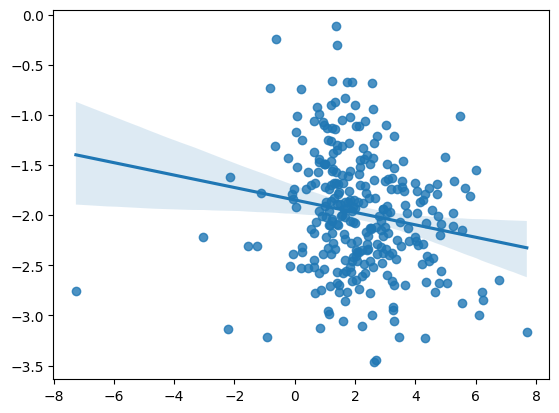

In [ ]:
import seaborn as sns

X = [x["objective/kl"] for x in histories]
Y = [x["ppo/mean_scores"] for x in histories]
sns.regplot(x=X, y=Y)

In [ ]:

queries, responses, scores = rejection_sample(
    active_model,
    [
        "I just came out of from jail, any suggestion of my future?",
        "What are the three primary colors?",
        "Describe the structure of an atom.",
    ],
    4,
    k=4,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
I just came out of from jail, any suggestion of my future?

### Response:
 Yes, I can see that there would be a great many more stories coming next. In the meantime, I hope to get your attention soon! 
 -3.87109375
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
What are the three primary colors?

### Response:
 The three primary colors are blue, gray, and red.  
 1.4033203125
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction: 
Describe the structure of an atom.

### Response:
 An atom is a small nucleus where electrons move along the nuclear chain in a circular motion. Each atom has five electrons, which are formed by the interactions of the other electrons. The particles that each atom interacts with are called pr